# 0.0. Imports

In [5]:
import json
import math
# import pylab 
import random
import pickle
import requests
import datetime
import warnings
warnings.filterwarnings( 'ignore')
import inflection
import numpy as np
import pandas as pd 
import seaborn as sns
import xgboost as xgb
                

from scipy                 import stats  as ss
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression
from sklearn.linear_model  import Lasso
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler


from flask                         import Flask, request, Response
from boruta                        import BorutaPy
from matplotlib                    import pyplot as plt
from matplotlib                    import gridspec
from IPython.display               import Image
from IPython.core.display          import HTML
from IPython.core.interactiveshell import InteractiveShell

%pylab inline
%matplotlib inline


plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24

display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option( 'display.expand_frame_repr', False )

sns.set();

Populating the interactive namespace from numpy and matplotlib


## 0.1 Helper Functions

## 0.2. Loading Data

In [6]:
df_raw = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')

## Attribute Information:

Thirteen (13) clinical features:

- **age**: age of the patient (years)
- **anaemia**: decrease of red blood cells or hemoglobin (boolean)
- **high blood pressure**: if the patient has hypertension (boolean)
- **creatinine phosphokinase (CPK)**: level of the CPK enzyme in the blood (mcg/L)
- **diabetes**: if the patient has diabetes (boolean)
- **ejection fraction**: percentage of blood leaving the heart at each contraction (percentage)
- **platelets**: platelets in the blood (kiloplatelets/mL)
- **sex**: woman or man (binary)
- **serum creatinine**: level of serum creatinine in the blood (mg/dL)
- **serum sodium**: level of serum sodium in the blood (mEq/L)
- **smoking**: if the patient smokes or not (boolean)
- **time**: follow-up period (days)
- **[target] death event**: if the patient deceased during the follow-up period (boolean)

In [7]:
df_raw.sample(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
46,51.0,0,1380,0,25,1,271000.0,0.9,130,1,0,38,1
25,80.0,0,148,1,38,0,149000.0,1.9,144,1,1,23,1
133,63.0,0,193,0,60,1,295000.0,1.3,145,1,1,107,0
235,77.0,1,109,0,50,1,406000.0,1.1,137,1,0,209,0
61,50.0,0,318,0,40,1,216000.0,2.3,131,0,0,60,1


# 1.0. STEP 01 - DESCRIPTION OF DATA

In [8]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [9]:
# rename columns so they are all tiny
cols_old = ['age', 'anaemia','creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine','serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [10]:
df1.sample(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
96,63.0,1,514,1,25,1,254000.00,1.30,134,1,0,83,0
261,62.0,1,655,0,40,0,283000.00,0.70,133,0,0,233,0
81,67.0,0,582,0,50,0,263358.03,1.18,137,1,1,76,0
265,50.0,1,298,0,35,0,362000.00,0.90,140,1,1,240,0
69,65.0,0,113,1,25,0,497000.00,1.83,135,1,0,67,1


## 1.2. Data Dimensions

In [11]:
print('Number of Rows : {}'.format(df1.shape[0]))
print('Number of Cols : {}'.format(df1.shape[1]))

Number of Rows : 299
Number of Cols : 13


## 1.3. Data Types

In [12]:
df1.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
death_event                   int64
dtype: object

## 1.4. Check NA

In [13]:
df1.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
death_event                 0
dtype: int64

## 1.5. Fillout NA

## 1.6. Change Data Types

## 1.7. Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

### 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( ['attributes','min','max','range','mean','median','std','skew','kurtosis'] )
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,40.0,95.0,-40.0,60.833893,60.0,11.874901,0.423062,-0.184871
1,anaemia,0.0,1.0,0.0,0.431438,0.0,0.495277,0.278261,-1.935563
2,creatinine_phosphokinase,23.0,7861.0,-23.0,581.839465,250.0,968.663967,4.463110,25.149046
3,diabetes,0.0,1.0,0.0,0.418060,0.0,0.493240,0.333929,-1.901254
4,ejection_fraction,14.0,80.0,-14.0,38.083612,38.0,11.815033,0.555383,0.041409
5,high_blood_pressure,0.0,1.0,0.0,0.351171,0.0,0.477336,0.626732,-1.618076
6,platelets,25100.0,850000.0,-25100.0,263358.029264,262000.0,97640.547655,1.462321,6.209255
7,serum_creatinine,0.5,9.4,-0.5,1.393880,1.1,1.032779,4.455996,25.828239
8,serum_sodium,113.0,148.0,-113.0,136.625418,137.0,4.405092,-1.048136,4.119712
9,sex,0.0,1.0,0.0,0.648829,1.0,0.477336,-0.626732,-1.618076


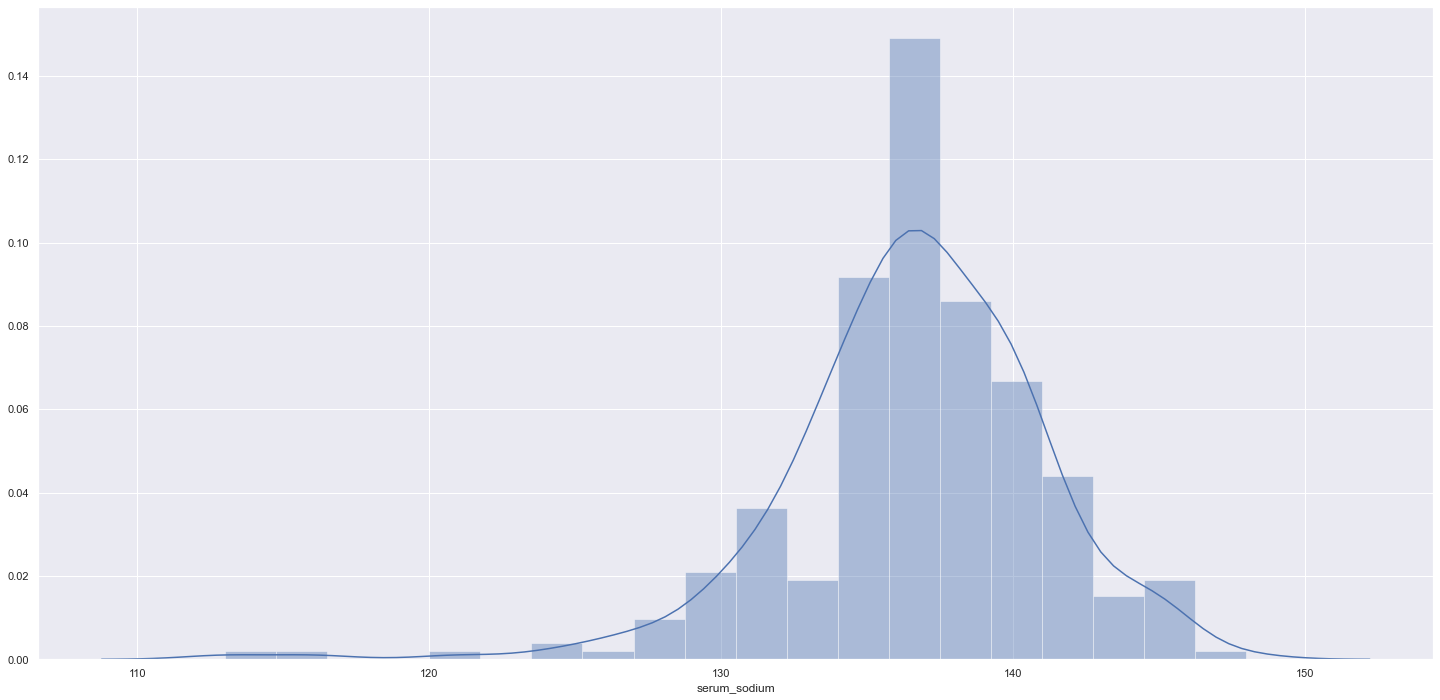

In [16]:
sns.distplot(df1['serum_sodium']);

### 1.7.2. Categorical Attributes

# 2.0. STEP 02 - FEATURE ENGINNERING

In [17]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

In [18]:
Image('img/MindMapHypothesis.png')

FileNotFoundError: No such file or directory: 'img/MindMapHypothesis.png'

FileNotFoundError: No such file or directory: 'img/MindMapHypothesis.png'

<IPython.core.display.Image object>

## 2.2. Creation of Hypotheses

### 2.2.1. Age Hypothesis

**1.** Men die more than women from heart attack

### 2.2.2. Sex Hypothesis

**1.** Men are more likely to die from heart disease than women.

### 2.2.3. Smooking Hypothesis

**1.** Men who smoke die more from heart attack than women.

### 2.2.4. Diabetes Hypothesis

**1.** People with Diabetes die more from heart attack than people without diabetes.

### 2.2.5. High Blood Pressure Hypothesis

**1.** Women with high blood pressure are more likely to die of a heart attack than men.

### 2.2.6. Anaemia Hypothesis

**1.** Pessoas com anemia morrem mais do que quem não tem anemia.

## 2.3. Feature Engineering

# 3.0. STEP 03 - VARIABLES FILTERING

In [19]:
df3 = df2.copy()

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS (EDA)

In [20]:
df4 = df3.copy()

In [21]:
df4.tail()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
294,62.0,0,61,1,38,1,155000.0,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.0,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.0,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.0,1.4,140,1,1,280,0
298,50.0,0,196,0,45,0,395000.0,1.6,136,1,1,285,0


### 4.1.1. Response Variable

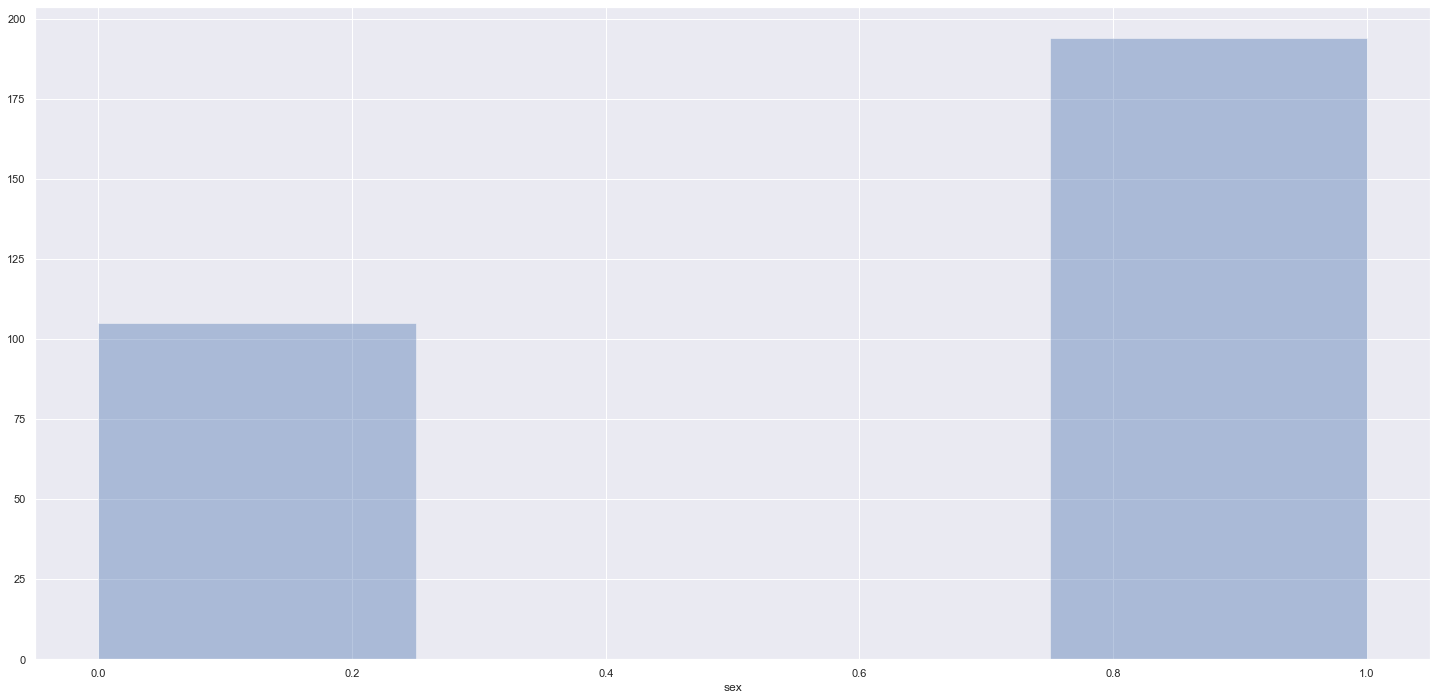

In [22]:
sns.distplot(df4['sex'], kde=False);

### 4.1.2. Numerical Variable

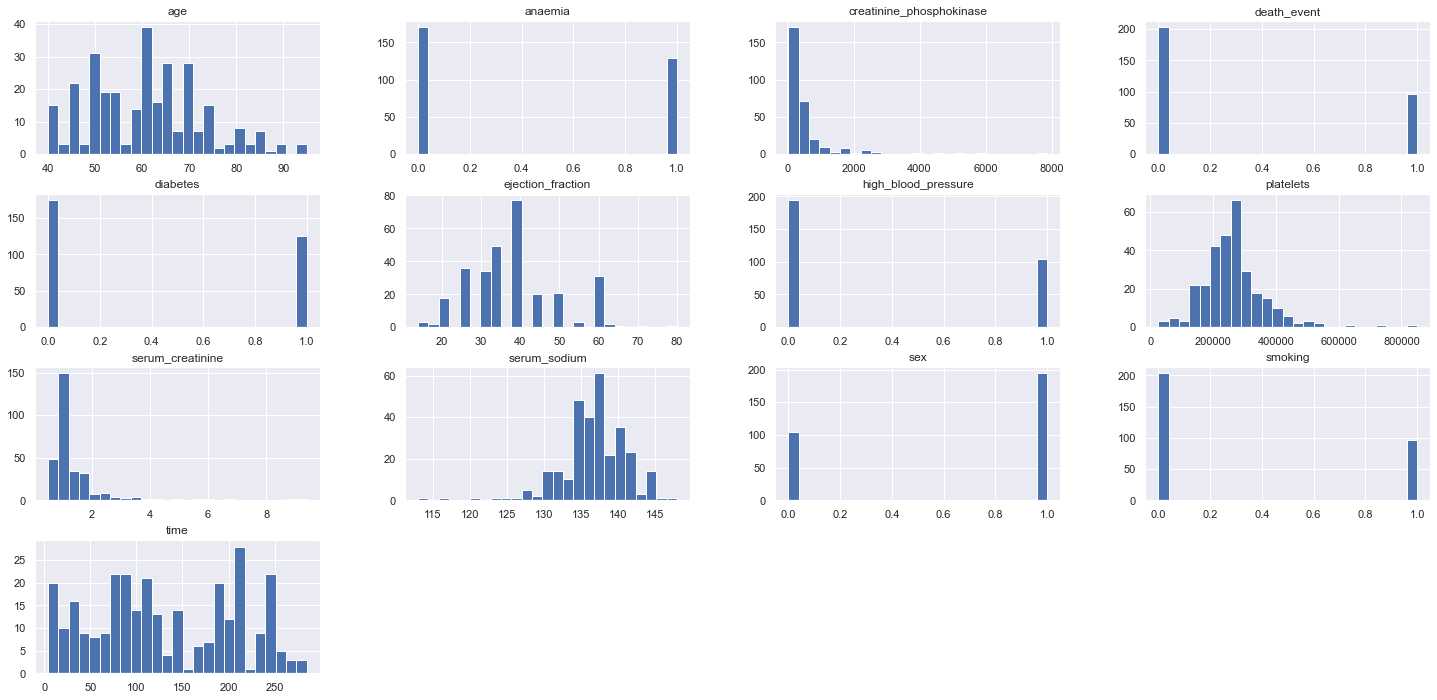

In [23]:
num_attributes.hist( bins=25);

## 4.2. Analise Bivariada

### **H1.** Men die more than women from heart attack

<AxesSubplot:xlabel='smoking', ylabel='death_event'>

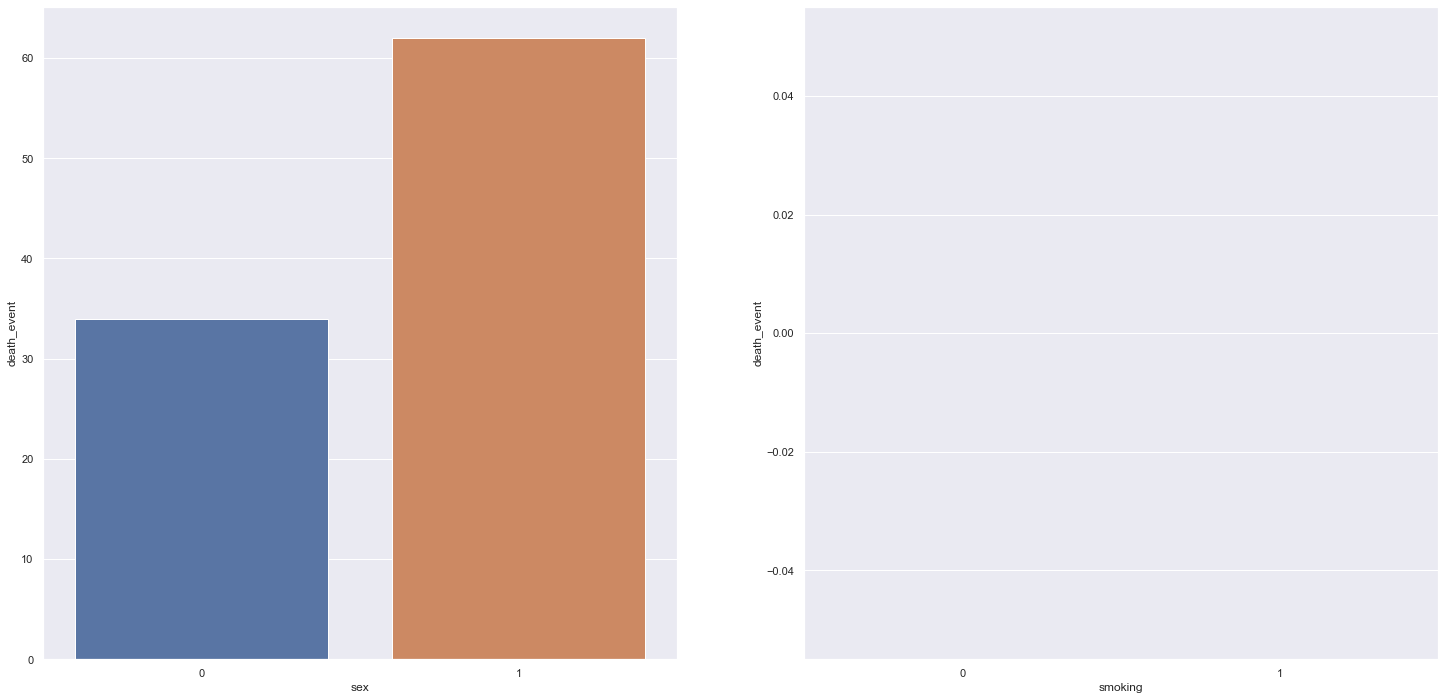

In [31]:
aux1 = df4[(df4['death_event'] == 1)]
aux2 = aux1[['sex', 'death_event']].groupby('sex').sum().reset_index()
aux3 = df4[(df4['death_event'] == 0)]
aux4 = aux3[['smoking', 'death_event']].groupby('smoking').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='sex', y='death_event', data=aux2)

plt.subplot(1,2,2)
sns.barplot(x='smoking', y='death_event', data=aux4)

In [25]:
aux1.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [26]:
print(len(aux4))


2


In [27]:
aux4

,sex,death_event
0,0,0
1,1,0
